# Sampling Weights

## Libraries & Functions Import

In [26]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import statsmodels
from statsmodels.tsa.stattools import acf
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score



#import functions from my scripts and book scripts

sys.path.append('../scripts')
from AFML_book_scripts import *
from AFML_my_scripts import *

## Concurrent Events and Volatility

From EXERCISE 4.1

In previous exercises we denoted as t1 a pandas series of timestamps where the first
barrier was touched, and the index was the timestamp of the observation. This
was the output of the getEvents function.

1. Compute a t1 series on dollar bars derived from E-mini S&P 500 futures
tick data.
2. Apply the function mpNumCoEvents to compute the number of overlapping
outcomes at each point in time.
3. Plot the time series of the number of concurrent labels on the primary axis,
and the time series of exponentially weighted moving standard deviation of
returns on the secondary axis.
4. Produce a scatterplot of the number of concurrent labels (x-axis) and the
exponentially weighted moving standard deviation of returns (y-axis). Can
you appreciate a relationship?

In [15]:
data = pd.read_csv('../data/btc_1h_data_2018_to_2025.csv')
df = pd.DataFrame(data)
df = df.rename(columns={'Close time': 'datetime', 'Open': 'open', 'High': 'high', 'Low': 'low', 'Close': 'close', 'Volume': 'volume'})
df = df.drop(columns=['Open time', 'Quote asset volume', 'Number of trades', 'Taker buy base asset volume', 'Taker buy quote asset volume', 'Ignore'],axis=1)
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.set_index('datetime') # Now set the index using the column name
df.index = df.index.round('H')
df = df[~df.index.duplicated(keep="first")]

C:\Users\dgalassi\AppData\Local\Temp\ipykernel_21092\1346818002.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df.index = df.index.round('H')


In [16]:
#calculate dialy volatility
daily_vol = df['close'].pct_change().resample('D').std()
#target will have the same daily vol for each observation belonging to the same day (so we assign tot he first hour and fill up to the next day)
target = daily_vol.reindex(df.index, method = 'ffill')
# vertical barrier is 1 day, so each positioning maximum lasts 24 hours
t1 = df.index + pd.Timedelta(days=1)
t1 = t1.where(t1 < df.index[-1], pd.NaT)
t1 = pd.Series(t1, index=df.index)


#parameters to pass

minRet = 2*target.mean()
ptSl = (1,1)
tEvents = df.index
trgt = target
#side = df.side
close = df.close
vert_barr = t1


In [17]:
# getEventsMeta is a function that will create the events based on the parameters provided
events = getEventsMeta(close, tEvents, ptSl, trgt, minRet, t1=vert_barr)
events.head()

,t1,trgt,side,hit_first
datetime,,,,
2018-01-01 01:00:00,2018-01-01 02:00:00,0.012352,1.0,sl
2018-01-01 02:00:00,2018-01-01 04:00:00,0.012352,1.0,tp
2018-01-01 03:00:00,2018-01-01 05:00:00,0.012352,1.0,tp
2018-01-01 04:00:00,2018-01-01 05:00:00,0.012352,1.0,tp
2018-01-01 05:00:00,2018-01-01 07:00:00,0.012352,1.0,tp


In [18]:
num_co_events = mpNumCoEvents(close.index, events.t1, events.index)
num_co_events.head()

datetime
2018-01-01 01:00:00    1
2018-01-01 02:00:00    2
2018-01-01 03:00:00    2
2018-01-01 04:00:00    3
2018-01-01 05:00:00    3
dtype: int64

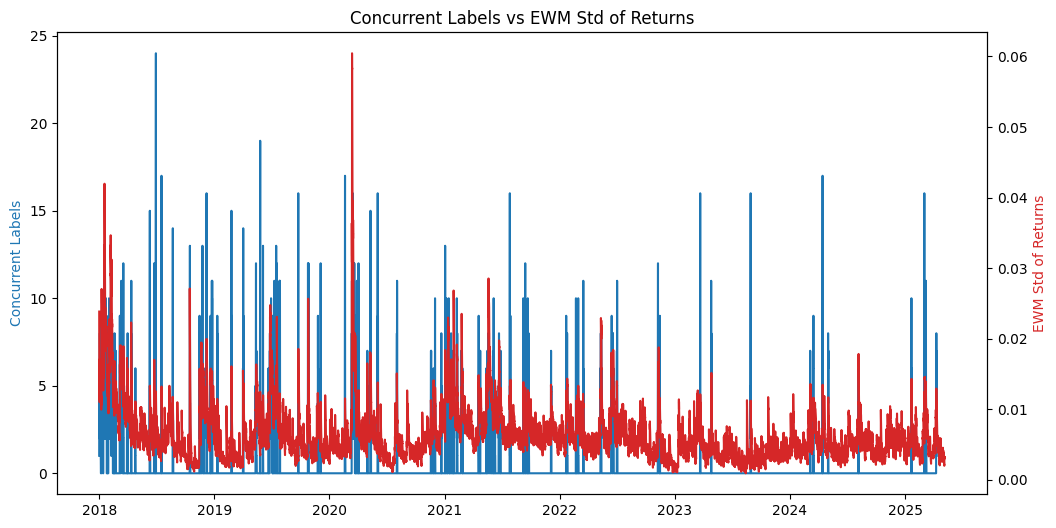

In [19]:
# compute log returns
ret = close.pct_change().dropna()

# exponentially weighted moving std (half-life=50 is common, can adjust)
ewm_std = ret.ewm(span=50).std()

fig, ax1 = plt.subplots(figsize=(12,6))

ax1.plot(num_co_events.index,num_co_events.values, label="Concurrent Labels", color="tab:blue")
ax1.set_ylabel("Concurrent Labels", color="tab:blue")

# second axis
ax2 = ax1.twinx()
ax2.plot(ewm_std.index, ewm_std, label="EWM Std of Returns", color="tab:red")
ax2.set_ylabel("EWM Std of Returns", color="tab:red")

plt.title("Concurrent Labels vs EWM Std of Returns")
plt.show()


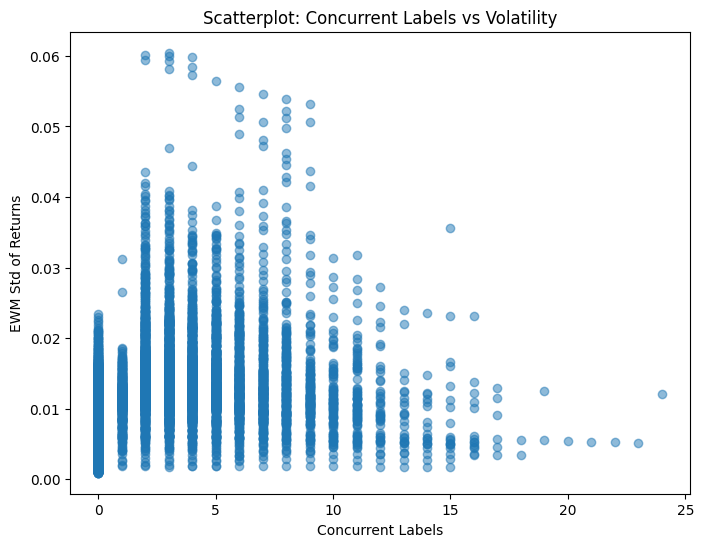

In [20]:
# Align indices (only keep common timestamps)
df_scatter = pd.concat([num_co_events, ewm_std], axis=1).dropna()
df_scatter.columns = ["ConcurrentLabels", "EWMStd"]

plt.figure(figsize=(8,6))
plt.scatter(df_scatter["ConcurrentLabels"], df_scatter["EWMStd"], alpha=0.5)
plt.xlabel("Concurrent Labels")
plt.ylabel("EWM Std of Returns")
plt.title("Scatterplot: Concurrent Labels vs Volatility")
plt.show()


## Average Uniqueness and AutoCorrelation

Using the function mpSampleTW, compute the average uniqueness of each label.

What is the first-order serial correlation, AR(1), of this time series? Is it statisti-
cally significant? Why?

In [21]:
avgU = sampleTW(events.t1, num_co_events, events.index)

In [22]:
# Compute autocorrelation function with confidence intervals
acf_vals, confint = acf(avgU, nlags=1, alpha=0.05)
print("ACF(1):", acf_vals[1])
print("95% CI:", confint[1])


ACF(1): 0.6729381026871054
95% CI: [0.6445745  0.70130171]


We notice that:

1. There is a quite strong autocorrelation
2. The 95IC does not contain zero indicating statistical significance

*Why is this happening?*

- Overlap structure: Labels often share observations in the time series, so if one event is highly “unique” (few overlaps), nearby events are likely to also be more unique.

- Market microstructure: Events (like price moves) tend to cluster, so consecutive labels might be influenced by the same underlying price dynamics.

- Sampling frequency: On dollar bars or tick bars, short-term clustering is common, amplifying short-term serial correlation in uniqueness.

## Uniqueness Importance in Classification Tasks

From EXERCISE 3.4

Fit a random forest to a financial dataset where the mean average uniquenss is << 1

1. What is the mean out-of-bag accuracy?
2. What is the mean accuracy of k-fold cross-validation (without shuffling) on
the same dataset?
3.  Why is out-of-bag accuracy so much higher than cross-validation accuracy?
Which one is more correct / less biased? What is the source of this bias?

In [23]:
#check the mean uniqueness

mean_uniqueness = avgU.mean()
print(mean_uniqueness)

0.2519254604647102


Let's say that 0.25 << 1 so my average(average uniquenss) is small enough...

importing some CSV generated in ... https://github.com/dgalassi99/quant-lab/blob/main/book_projects/Advances_Financial_Machine_Learning/projects/Trend_Following_Strategy_%26_MetaLabelling_Classification.ipynb

In [24]:
train_df = pd.read_csv('../data/Train_Test_prep_data/train.csv', index_col=0)
X_train = train_df.drop(columns='y')
y_train = train_df['y']

test_df = pd.read_csv('../data/Train_Test_prep_data/test.csv', index_col=0)
X_test = test_df.drop(columns='y')
y_test = test_df['y']


In [25]:
#visulaize where train and test datasetd end in time
print(f'X_train starts at {X_train .index[0]} and ends at {X_train.index[-1]}')
print(f'X_test starts at {X_test.index[0]} and ends at {X_test.index[-1]}')

X_train starts at 2018-01-02 01:00:00 and ends at 2021-02-24 13:00:00
X_test starts at 2021-02-24 14:00:00 and ends at 2025-04-09 23:00:00


In [27]:
# Initialize RF with OOB score enabled
rf = RandomForestClassifier(
    n_estimators=100,
    max_features='sqrt',
    oob_score=True,
    random_state=42,
    n_jobs=-1
)

# Fit on training data
rf.fit(X_train, y_train)

# (a) Out-of-bag accuracy
oob_acc = rf.oob_score_
print(f"Out-of-bag accuracy: {oob_acc:.4f}")

# (b) k-fold cross-validation accuracy (without shuffling)
cv_scores = cross_val_score(rf, X_train, y_train, cv=5, n_jobs=-1)
cv_acc = cv_scores.mean()
print(f"5-fold CV accuracy: {cv_acc:.4f}")

# (c) Comparison
print("\nObservation:")
print("OOB accuracy is typically higher than CV accuracy in this setup because:")
print("- The data is time series / non-i.i.d.; OOB samples are drawn from the bootstrap and may not reflect true temporal dependencies.")
print("- CV without shuffling respects order, so the test folds include unseen temporal patterns, leading to lower (more realistic) accuracy.")
print("=> CV accuracy is generally less biased and a better estimate of out-of-sample performance.")


Out-of-bag accuracy: 0.8301
5-fold CV accuracy: 0.5233

Observation:
OOB accuracy is typically higher than CV accuracy in this setup because:
- The data is time series / non-i.i.d.; OOB samples are drawn from the bootstrap and may not reflect true temporal dependencies.
- CV without shuffling respects order, so the test folds include unseen temporal patterns, leading to lower (more realistic) accuracy.
=> CV accuracy is generally less biased and a better estimate of out-of-sample performance.


## Importanced of a Balanced Classed and of Rebalancing 

From EXERCISE 4.5

Consider you have applied meta-labels to events determined by a trend-following
model. Suppose that two thirds of the labels are 0 and one third of the labels
are 1.
1.  What happens if you fit a classifier without balancing class weights?
 
Fitting without balancing will result in a model tha is going to most-likely predict a lot of 0. Due to unbalance if the algorithm predicts all zeros it already has a 66.6% accuracy.

2. A label 1 means a true positive, and a label 0 means a false positive. By
applying balanced class weights, we are forcing the classifier to pay more
attention to the true positives, and less attention to the false positives. Why
does that make sense?

- Because to not "bias" the classifier we want him to find true positives as it could happen that those rarer events are indeed financially more important

3. What is the distribution of the predicted labels, before and after applying
balanced class weights?

- When not balancing we ar emost likely to observe mostly yi == 0 for each i, when balancing indeed we expect the distribution to follow the distribution of the expected (test)label class



In [28]:

# 1) Without class weights
rf1 = RandomForestClassifier(class_weight=None, random_state=42)
rf1.fit(X_train, y_train)
pred1 = rf1.predict(X_train)

# 2) With balanced class weights
rf2 = RandomForestClassifier(class_weight='balanced', random_state=42)
rf2.fit(X_train, y_train)
pred2 = rf2.predict(X_train)

In [30]:
# Predictions on the test set
pred_test1 = rf1.predict(X_test)
pred_test2 = rf2.predict(X_test)

print("Distribution of the known label:")
print(y_train.value_counts(normalize=True))

print("Distribution on X_test without class weights:")
print(pd.Series(pred_test1).value_counts(normalize=True))

print("Distribution on X_test with balanced class weights:")
print(pd.Series(pred_test2).value_counts(normalize=True))


Distribution of the known label:
y
1.0    0.62797
0.0    0.37203
Name: proportion, dtype: float64
Distribution on X_test without class weights:
1.0    0.520337
0.0    0.479663
Name: proportion, dtype: float64
Distribution on X_test with balanced class weights:
1.0    0.593969
0.0    0.406031
Name: proportion, dtype: float64


Observe that when balancing the distribution of the predicted class is much closer to the one of the data used to train the model with!!!